<a href="https://colab.research.google.com/github/polortiz4/Smart-Cameras/blob/master/HW4/Learning%20to%20Focus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ECE 590 Smart Cameras 
## Fall 2019
## Homework 4
## Learning to Focus

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import subprocess
import scipy
import skimage
import skimage.io as imio
import skimage.color as color
import skimage.transform as trans
from skimage.viewer import ImageViewer
import glob
from time import gmtime, strftime, sleep
import random
from scipy.io import loadmat
import os
import cv2
%matplotlib inline
mpl.rcParams['figure.figsize'] = (16.0, 8.0) 

/usr/local/lib/python3.6/dist-packages/skimage/viewer/__init__.py:6: UserWarning: Viewer requires Qt
  warn('Viewer requires Qt')


The file defocus.mat provides a focus model for the the tegra camera on line at nvidia@10.236.176.37. The structure of the model is discussed in the paper "Intelligent Autofocus" distributed in class. The model is a 210*4 matrix. The first column is the focus position Z_0, the second column is the defocus position Z_i, the third column is the defocus radius r for disk filter, and the fourth column is the scaling factor \alpha. (Same notations as in the paper, Section III IMAGE DEFOCUS MODEL)

The focus on this camera is adjusted using the python scripts moveFocusMotor.py and resetFocusMotor.py as in previous homework. You can see the current focus position by running the command python2 

moveFocusMotor.py sid 0

where sid is the sensor number. sid can be 1 or 2, corresponding as before to sensor 0 or 1 for the nvgstcapture command. 

In [0]:
os.chdir('/content/gdrive/My Drive/Smart-Cameras/HW4')
deFocusModel = loadmat('defocus.mat')["defocus_model"]

As shown in the plot below, the focus position scales between 1100 and 2000. The defocus position can then scale between 1100 and 2000, as shown in the orange curve, for each defocus value, there is a corresponding defocus blur diameter, as shown in the green curve at the bottom.

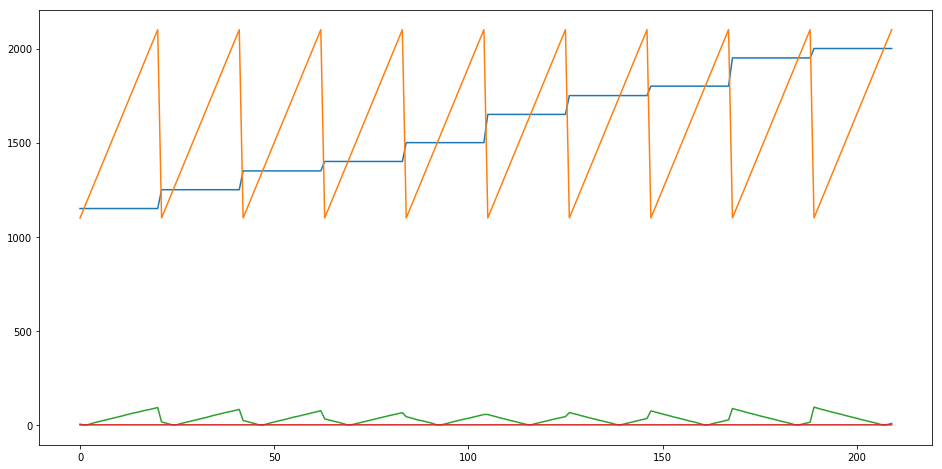

In [0]:
plt.plot(deFocusModel)

In this homework you should use the high resolution images in the libraries at 

CLIC dataset
http://www.compression.cc/challenge/

DIV2K
https://data.vision.ee.ethz.ch/cvl/DIV2K/

To generate training and test image data sets corresponding to {blurredImage, AbsoluteRangeToFocusPosition} pairs. Use the training data (with patch size 256) to train a network to estimate absolute range to focus position from an input image. Test your train network with the task of focusing the camera on online at nvidia@10.236.176.37  

The camera contains objects at various fields of view within its range, test separately on different regions of interest to evaluate your autofocus system. 

# Generate Training and Test data

In [0]:
def divide_image(image, block_size = 512):
    blocks = np.zeros([1, block_size, block_size])
    for row in range(int(image.shape[0] / block_size)):
        for col in range (int(image.shape[1] / block_size)):
            block = image[block_size*row : block_size*row + block_size, block_size*col : block_size*col + block_size, :]
            blocks = np.append(blocks, block[np.newaxis, :, :], axis = 0)
    
    return blocks

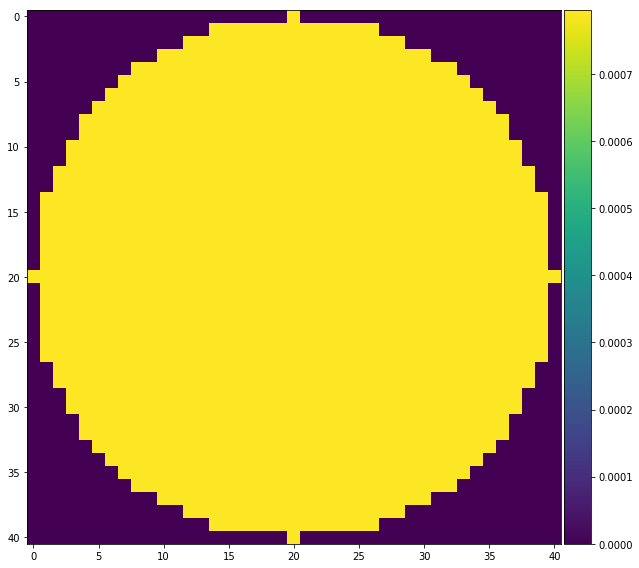

In [0]:
def kernel(r, pitch = 1.62):
    if r == 0:
        r = 1.62
    r_length = int(r / pitch)
    x = np.arange(-r_length, r_length + 1)
    y = np.arange(-r_length, r_length + 1)
    xx, yy = np.meshgrid(x, y)
    kernel = np.zeros_like(xx)
    kernel = (xx**2 + yy**2 <= r_length**2) / np.pi / r_length**2
    kernel = kernel / sum(sum(kernel))
    
    return kernel
kernel_example = kernel(33)
imio.imshow(kernel_example)

In [0]:
def forward_model(image, r, alpha = 1):
    blur = scipy.signal.convolve2d(image, kernel(r), mode = 'valid')
    blur_scale = cv2.resize(blur, None, fx = alpha, fy = alpha)
    
    return blur_scale

In [0]:
def pre_process(filename, folder, r, alpha = 1, block_size = 512):
    image = imio.imread(folder + filename) # Read image
    image = color.rgb2gray(image)
    image = image[:int(block_size + max(deFocusModel[:, 2])), :int(block_size + max(deFocusModel[:, 2]))]
    image = forward_model(image, r, alpha) # Apply forward model
#     blocks = divide_image(image, block_size) # Extract 512 blocks
    crop = image[:512, :512]
    
    return crop # For now, only return one block cause my memory is killing me

In [0]:
num_train = len(os.listdir('train'))
print('num_trian: ' + str(num_train))
x_train = np.zeros([1, 512, 512])
y_train = []
for i, filename in  enumerate(os.listdir('train')[:num_train]):
    print('i: ' + str(i))
    z0 = random.choice(np.unique(deFocusModel[:, 0]))
    z1 = random.choice(np.unique(deFocusModel[:, 1]))
    r = deFocusModel[np.where(np.multiply(deFocusModel[:, 1] == z1, deFocusModel[:, 0] == z0)), 2]
    alpha = deFocusModel[np.where(np.multiply(deFocusModel[:, 1] == z1, deFocusModel[:, 0] == z0)), 3]
    block = pre_process(filename, folder = 'train/', r = r, alpha = alpha)
    try:
        x_train = np.append(x_train, block[np.newaxis, :, :] , axis = 0)
        y_train = np.append(y_train, abs(z1 - z0))
    except:
        pass    

num_trian: 1633
i: 0
i: 1
i: 2
i: 3
i: 4
i: 5
i: 6
i: 7
i: 8
i: 9
i: 10
i: 11
i: 12
i: 13
i: 14
i: 15
i: 16
i: 17
i: 18
i: 19
i: 20
i: 21


/Users/pabloortiz/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/pabloortiz/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


i: 22
i: 23
i: 24
i: 25
i: 26
i: 27
i: 28
i: 29
i: 30
i: 31
i: 32
i: 33
i: 34
i: 35
i: 36
i: 37
i: 38
i: 39
i: 40
i: 41
i: 42
i: 43
i: 44
i: 45
i: 46
i: 47
i: 48
i: 49
i: 50
i: 51
i: 52
i: 53
i: 54
i: 55
i: 56
i: 57
i: 58
i: 59
i: 60
i: 61
i: 62
i: 63
i: 64
i: 65
i: 66
i: 67
i: 68
i: 69
i: 70
i: 71
i: 72
i: 73
i: 74
i: 75
i: 76
i: 77
i: 78
i: 79
i: 80
i: 81
i: 82
i: 83
i: 84
i: 85
i: 86
i: 87
i: 88
i: 89
i: 90
i: 91
i: 92
i: 93
i: 94
i: 95
i: 96
i: 97
i: 98
i: 99
i: 100
i: 101
i: 102
i: 103
i: 104
i: 105
i: 106
i: 107
i: 108
i: 109
i: 110
i: 111
i: 112
i: 113
i: 114
i: 115
i: 116
i: 117
i: 118
i: 119
i: 120
i: 121
i: 122
i: 123
i: 124
i: 125
i: 126
i: 127
i: 128
i: 129
i: 130
i: 131
i: 132
i: 133
i: 134
i: 135
i: 136
i: 137
i: 138
i: 139
i: 140
i: 141
i: 142
i: 143
i: 144
i: 145
i: 146
i: 147
i: 148
i: 149
i: 150
i: 151
i: 152
i: 153
i: 154
i: 155
i: 156
i: 157
i: 158
i: 159
i: 160
i: 161
i: 162
i: 163
i: 164
i: 165
i: 166
i: 167
i: 168
i: 169
i: 170
i: 171
i: 172
i: 173
i: 174
i: 175


#### To verify that the forward model is working, we run it in one of the images and should observe both smoothing and scaling. As observed, the image is smoothed and the size is doubled (look at the number of pixels in the axis labels)

(512, 512)
10
(13, 13)


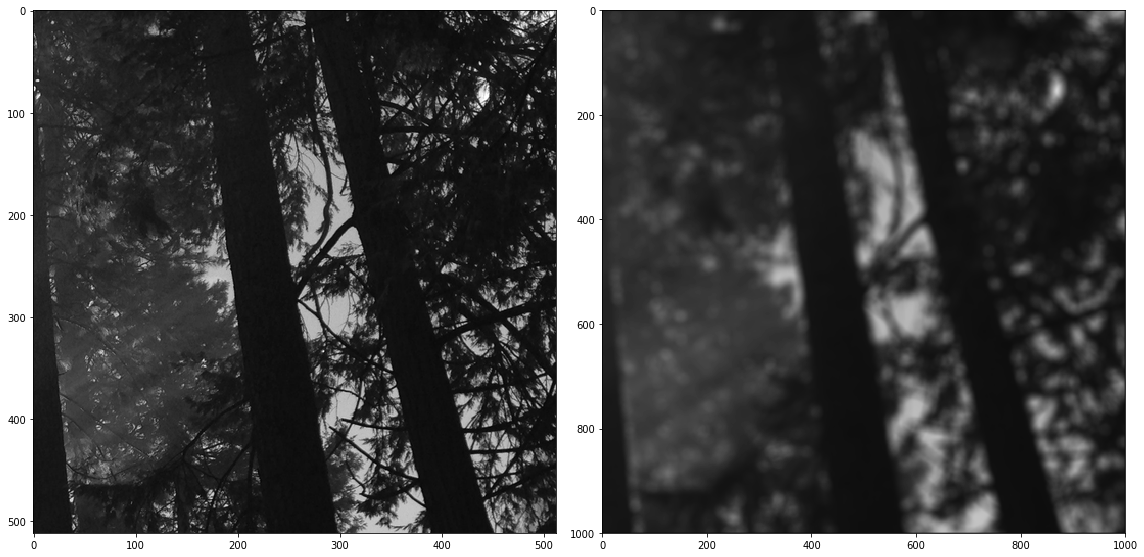

In [0]:
plt.subplot(1, 2, 2)
imio.imshow(forward_model(x_train[4, :, :], 10, 2))
plt.subplot(1, 2, 1)
imio.imshow(x_train[4, :, :])

In [0]:
num_validate = len(os.listdir('valid'))# int(0.4286 * num_train)
x_valid = np.zeros([1, 512, 512])
y_valid = []
for i, filename in  enumerate(os.listdir('valid')[:num_validate]):
    z0 = random.choice(np.unique(deFocusModel[:, 0]))
    z1 = random.choice(np.unique(deFocusModel[:, 1]))
    r = deFocusModel[np.where(np.multiply(deFocusModel[:, 1] == z1, deFocusModel[:, 0] == z0)), 2]
    alpha = deFocusModel[np.where(np.multiply(deFocusModel[:, 1] == z1, deFocusModel[:, 0] == z0)), 3]
    block = pre_process(filename, folder = 'valid/', r = r, alpha = alpha)
    try:
        x_valid = np.append(x_train, block[np.newaxis, :, :], axis = 0)
        y_valid = np.append(y_train, abs(z1 - z0))
    except:
        pass

In [0]:
np.save('train_data', x_train)
np.save('train_label', y_train)
np.save('valid_label', y_valid)
np.save('valid_data', x_valid)

In [0]:
train_truth.shape

(686, 512, 512)

In [0]:
validate_truth.shape

(308, 512, 512)

In [0]:
np.unique(deFocusModel[:, 0])

array([1150., 1250., 1350., 1400., 1500., 1650., 1750., 1800., 1950.,
       2000.])

In [0]:
random.choice([1,2,3,4])

4

In [0]:
max(deFocusModel[:, 2])

95.0